# Import and Clean Data

The data must be imported from a CSV file, cleaned to the standards of the question being asked, and adapted into a neural network input.


## References

 * [Andrew Long](https://github.com/andrewwlong/diabetes_readmission/blob/master/diabetes_project.ipynb)
 * [Sheng Weng](https://github.com/swengzju/Predicting-Diabetes-Patient-Readmission/blob/master/Predicting%20Diabetes%20Patient%20Readmission.ipynb)
 * [Bose, et al.](https://github.com/Yawhoong/ISS-Diabetes-Readmission/blob/master/Identification%20of%20Critical%20Risk%20Factors%20leading%20to%20short-term%20readmission%20of%20Diabetic%20Patients.pdf)


In [1]:
# Import modules and data
import pandas as pd
import numpy as np

df = pd.read_csv("diabetic_data.csv")
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [2]:
# Determine whether the diabetes diagnosis was in the top 3
# Drop the diagnoses, they are too scattered
import re
DIABETES_REGEX = re.compile("250")
isDiabetes = lambda s: DIABETES_REGEX.match(s)
df["primary_diag"] = (df["diag_1"].str.contains("^250") |
                      df["diag_2"].str.contains("^250") |
                      df["diag_3"].str.contains("^250")).astype("int")
df.drop(["diag_1", "diag_2", "diag_3"], axis=1, inplace=True)
df.groupby("primary_diag").size()

primary_diag
0    63742
1    38024
dtype: int64

In [3]:
# Remove columns...
#  * encounter_id, patient_nbr (identification)
#  * weight, payer_code, medical_specialty (too sparse)
#  * diag_1, diag_2, diag_3 (too specific)
df.drop(["encounter_id", "patient_nbr", "weight", "payer_code", "medical_specialty"], axis=1, inplace=True)
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,primary_diag
0,Caucasian,Female,[0-10),6,25,1,1,41,0,1,...,No,No,No,No,No,No,No,No,NO,1
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,...,Up,No,No,No,No,No,Ch,Yes,>30,1
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,Yes,NO,1
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,...,Up,No,No,No,No,No,Ch,Yes,NO,1
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,...,Steady,No,No,No,No,No,Ch,Yes,NO,1


In [4]:
# Filter by...
#  * Must have a gender
df = df[df["gender"] != "Unknown/Invalid"]

#  * Must not be discharged by death or hospice
df = df.loc[~df["discharge_disposition_id"].isin([11, 13, 14, 19, 20, 21])]

df.shape

(99340, 43)

In [5]:
# Normalize continuous columns to [0, 1]
cols_continuous = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses']

for col in cols_continuous:
    lo, hi = df[col].min(), df[col].max()
    df[col] = (df[col] - lo) / (hi - lo)

In [6]:
# Normalize numerically-categorical columns (i.e. age)
AGE_MAPPING = {"[{}-{})".format(i * 10, (i + 1) * 10): i * 0.1 + 0.05 for i in range(10)}
df["age"] = df["age"].apply(lambda s: AGE_MAPPING[s])
df[["age"] + cols_continuous].head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
0,0.05,0.000000,0.305344,0.000000,0.0000,0.000000,0.0,0.000000,0.000000
1,0.15,0.153846,0.442748,0.000000,0.2125,0.000000,0.0,0.000000,0.533333
2,0.25,0.076923,0.076336,0.833333,0.1500,0.047619,0.0,0.047619,0.333333
3,0.35,0.076923,0.328244,0.166667,0.1875,0.000000,0.0,0.000000,0.400000
4,0.45,0.000000,0.381679,0.000000,0.0875,0.000000,0.0,0.000000,0.266667


In [7]:
# Manipulate categorical columns
cols_categorical = ['race', 'gender',
        'admission_type', 'admission_source',
        'max_glu_serum', 'A1Cresult',
        'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
        'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
        'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
        'tolazamide', 'insulin',
        'glyburide-metformin', 'glipizide-metformin',
        'glimepiride-pioglitazone', 'metformin-rosiglitazone',
        'metformin-pioglitazone', 'change', 'diabetesMed',
        'examide', 'citoglipton']

# Create an "Unknown" category for race
df["race"] = df["race"].replace("?", "Unknown")

# Consolidate admissions types
ADMISSION_TYPE_MAPPING = {
    1: "Emergency",
    2: "Urgent",
    3: "Elective"
}
df["admission_type_id"] = df["admission_type_id"].apply(lambda s: ADMISSION_TYPE_MAPPING.get(s, "Other"))

# Discharge disposition is either going home OK or not going home OK
df["discharge_disposition_id"] = (df["discharge_disposition_id"] == 1).astype("int")

# Admission source is either Emergency, Referral, or Other
ADMISSION_SOURCE_MAPPING = {
    1: "EmergencyRoom",
    7: "Referral"
}
df["admission_source_id"] = df["admission_type_id"].apply(lambda s: ADMISSION_SOURCE_MAPPING.get(s, "Other"))

df.rename(columns={
    "admission_type_id": "admission_type",
    "discharge_disposition_id": "discharged_home",
    "admission_source_id": "admission_source"}, inplace=True)
#df["race", "admission_type", "admission_source", "discharged_home"].head()
df.head()

,race,gender,age,admission_type,discharged_home,admission_source,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,primary_diag
0,Caucasian,Female,0.05,Other,0,Other,0.000000,0.305344,0.000000,0.0000,...,No,No,No,No,No,No,No,No,NO,1
1,Caucasian,Female,0.15,Emergency,1,Other,0.153846,0.442748,0.000000,0.2125,...,Up,No,No,No,No,No,Ch,Yes,>30,1
2,AfricanAmerican,Female,0.25,Emergency,1,Other,0.076923,0.076336,0.833333,0.1500,...,No,No,No,No,No,No,No,Yes,NO,1
3,Caucasian,Male,0.35,Emergency,1,Other,0.076923,0.328244,0.166667,0.1875,...,Up,No,No,No,No,No,Ch,Yes,NO,1
4,Caucasian,Male,0.45,Emergency,1,Other,0.000000,0.381679,0.000000,0.0875,...,Steady,No,No,No,No,No,Ch,Yes,NO,1


In [8]:
# Handle categorical columns...
#  1. Remove categorical columns that are almost uniform (>99% of entries are one thing)
#  2. Split other columns into multiple boolean columns
n_rows = df.shape[0]
cols_insignificant = []
cols_significant = []
for col in cols_categorical:
    freqs = dict(df.groupby(col).size())
    
    # Remove this column
    if any([float(value)/float(n_rows) > 0.99 for value in freqs.values()]):
        cols_insignificant.append(col)
    
    else:
        # Sanity check
        assert(len(freqs) > 1)
        cols_significant.append(col)
        
        # Convert to column to string if not already string type
        if df[col].dtype != str:
            df[col] = df[col].astype(str)
            
# Extract output
df_output = pd.get_dummies(df["readmitted"])
df.drop(["readmitted"], axis=1, inplace=True)

df_cat = pd.get_dummies(df[cols_significant], drop_first=False)
df_input = pd.concat([df, df_cat], axis=1)

df_input.drop(cols_insignificant + cols_significant, axis=1, inplace=True)

print("Insignificant: {}".format(cols_insignificant))
print("Significant: {}".format(cols_significant))
df_input.head()

Insignificant: ['admission_source', 'nateglinide', 'chlorpropamide', 'acetohexamide', 'tolbutamide', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'examide', 'citoglipton']
Significant: ['race', 'gender', 'admission_type', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change', 'diabetesMed']


,age,discharged_home,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,rosiglitazone_Steady,rosiglitazone_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
0,0.05,0,0.000000,0.305344,0.000000,0.0000,0.000000,0.0,0.000000,0.000000,...,0,0,0,1,0,0,0,1,1,0
1,0.15,1,0.153846,0.442748,0.000000,0.2125,0.000000,0.0,0.000000,0.533333,...,0,0,0,0,0,1,1,0,0,1
2,0.25,1,0.076923,0.076336,0.833333,0.1500,0.047619,0.0,0.047619,0.333333,...,0,0,0,1,0,0,0,1,0,1
3,0.35,1,0.076923,0.328244,0.166667,0.1875,0.000000,0.0,0.000000,0.400000,...,0,0,0,0,0,1,1,0,0,1
4,0.45,1,0.000000,0.381679,0.000000,0.0875,0.000000,0.0,0.000000,0.266667,...,0,0,0,0,1,0,1,0,0,1


At this point, all cells in the data should be numeric between 0 and 1. There are three different outcomes represented. Outputs are left in the same table as inputs to ensure that they do not get scrambled.

In [9]:
df = pd.concat([df_input, df_output], axis=1)
df.rename(columns={"<30": "OUTPUT_<30", ">30": "OUTPUT_>30", "NO": "OUTPUT_NO"}, inplace=True)
df.head()

,age,discharged_home,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,OUTPUT_<30,OUTPUT_>30,OUTPUT_NO
0,0.05,0,0.000000,0.305344,0.000000,0.0000,0.000000,0.0,0.000000,0.000000,...,1,0,0,0,1,1,0,0,0,1
1,0.15,1,0.153846,0.442748,0.000000,0.2125,0.000000,0.0,0.000000,0.533333,...,0,0,1,1,0,0,1,0,1,0
2,0.25,1,0.076923,0.076336,0.833333,0.1500,0.047619,0.0,0.047619,0.333333,...,1,0,0,0,1,0,1,0,0,1
3,0.35,1,0.076923,0.328244,0.166667,0.1875,0.000000,0.0,0.000000,0.400000,...,0,0,1,1,0,0,1,0,0,1
4,0.45,1,0.000000,0.381679,0.000000,0.0875,0.000000,0.0,0.000000,0.266667,...,0,1,0,1,0,0,1,0,0,1


# Neural Network

Bose, et al. used a neural network with the following parameters to model the given data:

 * Layers:
    1. Input (size = 70)
    2. Hidden Layer 1 (size = 70, ReLU activation)
    3. Hidden Layer 2 (size = 20, ReLU activation)
    4. Output Layer (size = 2, softmax)  
 * Dropout Rate: 0.1
 * Batch Size: 100
 * Epoch Size: 50
 * Optimization Algorithm: Adaptive Moment Estimation
 * Cost Function: Optimizes for recall
 
[This tutorial](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/multilayer_perceptron.py) is useful for implementing a basic multi-layer perceptron classifier.

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Hyperparameters
N_INPUTS = 67

## Data Separation

The data is separated into training, validation, and testing pools using a random number generator always seeded with the same value (so separation occurs the same way every time)

In [11]:
# Pull out validation (15%) and test (15%) data from training (70%) data
df_valid_test = df.sample(frac=0.3, random_state=0xda)
df_training = df.drop(df_valid_test.index)

df_valid = df_valid_test.sample(frac=0.5, random_state=0xdb)
df_test = df_valid_test.drop(df_valid.index, axis=0)

df_training.shape[0], df_valid.shape[0], df_test.shape[0]

(69538, 14901, 14901)

## Batches

The following class can be used as an iterable in a `for` loop. It takes a dynamic collection of data separated into pools (e.g. categories like readmission vs. no readmission) and produces a batch which samples equally frequently from each pool. The iterable stops when all data in the largest pool have been iterated over once

In [12]:
class TrainingBatches:

    def __init__(self, nn, batch_size=16):
        self.nn = nn
        self.batch_size = batch_size
        self.bounds = max([d.shape[0] for d in nn.training_data])
        self.it = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self.it >= self.bounds:
            raise StopIteration

        output = np.concatenate([self.getSlice(d, self.it, self.batch_size) for d in self.nn.training_data])
        self.it += self.batch_size
        return output[:, :N_INPUTS], output[:, N_INPUTS:]

    # Code must work with Python 2 and 3
    next = __next__

    def getSlice(self, array, start, length):
        start = start % array.shape[0]
        if start + length >= array.shape[0]:
            return np.concatenate((array[start:], array[:(start + length) % array.shape[0]]), axis=0)
        else:
            return array[start:start + length]

In [13]:
class CategoricalPreprocessor:
    
    def __init__(self, df, output_categories):
        self.output_categories = output_categories
        self.df = df
        self.is_modified = False
        
    def modifyDatafile(self):
        
        if self.is_modified:
            return self.df
        
        self.df = self.df.copy()
        self.is_modified = True
        
        if self.output_categories == "any":
            self.df["OUTPUT_ANY"] = self.df["OUTPUT_<30"] + self.df["OUTPUT_>30"]
            self.df.drop(["OUTPUT_<30", "OUTPUT_>30"], axis=1, inplace=True)

        elif self.output_categories == "rapid":
            self.df["OUTPUT_NO"] = self.df["OUTPUT_>30"] + self.df["OUTPUT_NO"]
            self.df.drop(["OUTPUT_>30"], axis=1, inplace=True)
            
        return self.df
    
    def getArraysByOutput(self):
        
        if not self.is_modified:
            self.modifyDatafile()
            
        if self.output_categories == "three":
            return (
                self.df[self.df["OUTPUT_<30"] == 1].to_numpy(),
                self.df[self.df["OUTPUT_>30"] == 1].to_numpy(),
                self.df[self.df["OUTPUT_NO"] == 1].to_numpy()
            )

        elif self.output_categories == "any":
            return (
                self.df[self.df["OUTPUT_ANY"] == 1].to_numpy(),
                self.df[self.df["OUTPUT_NO"] == 1].to_numpy()
            )

        else:
            return (
                self.df[self.df["OUTPUT_<30"] == 1].to_numpy(),
                self.df[self.df["OUTPUT_NO"] == 1].to_numpy()
            )

## Neural Network Generator

The following class dynamically generates a neural network with its own training and validation data

In [14]:
class NeuralNetwork:

    def __init__(self, df, df_validation, layer_sizes, output_categories, dropout, batch_size):
        self.dropout = dropout
        self.output_categories = output_categories
        self.batch_size = batch_size
        self.layer_sizes = layer_sizes
        
        # Parameter to horizontally compress the sigmoid activation
        self.activation_param = 1.0
        
        # Prepare training data
        training_processor = CategoricalPreprocessor(df, output_categories)
        self.training_data = training_processor.getArraysByOutput()
        
        # Prepare training batches
        training_in_out = list(iter(TrainingBatches(self, 32)))
        self.training_in = np.concatenate([i for i, o in training_in_out])
        self.training_out = np.concatenate([o for i, o in training_in_out])
        
        # Prepare validation data
        validation_processor = CategoricalPreprocessor(df_validation, output_categories)
        self.validation_data = validation_processor.modifyDatafile().to_numpy()
        self.validation_in = self.validation_data[:, :N_INPUTS]
        self.validation_out = self.validation_data[:, N_INPUTS:]
        
        self.classifier = self.makeClassifier()
        
        
    def parametrizedSigmoid(self):
        
        def sigmoid(x):
            # In the original Tensorflow code, x is a Tensor
            # For efficiency, x will be scalar-multiplied by the sigmoid
            # parameter and then passed to tf.math.sigmoid
            scaled = tf.math.scalar_mul(self.activation_param, x)
            return tf.math.sigmoid(scaled)
        
        return sigmoid
    
    
    def makeClassifier(self):
        
        # Create layers
        classifier = tf.keras.Sequential()
        classifier.add(tf.keras.layers.Dense(
            self.layer_sizes[0], activation=self.parametrizedSigmoid(), kernel_initializer="random_normal", input_dim=N_INPUTS))
        classifier.add(tf.keras.layers.Dropout(self.dropout))
        for size in self.layer_sizes[1:]:
            classifier.add(tf.keras.layers.Dense(
                size, activation=self.parametrizedSigmoid(), kernel_initializer="random_normal"))
            classifier.add(tf.keras.layers.Dropout(self.dropout))
        classifier.add(tf.keras.layers.Dense(
            len(self.training_data), activation="softmax", kernel_initializer="random_normal"))
        
        # Compile model
        classifier.compile(optimizer="adam", loss="binary_crossentropy",
                                metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])
        
        return classifier
        
        
    def train(self, epochs=20):
        return self.classifier.fit(self.training_in, self.training_out,
                                   validation_data=(self.validation_in, self.validation_out),
                                   batch_size=self.batch_size,
                                   epochs=epochs)

    
    def steepen(self):
        # Preserve old parameters
        params = [layer.get_weights() for layer in self.classifier.layers if type(layer) == tf.keras.layers.Dense]
        
        # Construct a new model
        self.activation_param *= 2
        self.classifier = self.makeClassifier()
        
        # Apply old parameters
        for layer, param in zip([layer for layer in self.classifier.layers if type(layer) == tf.keras.layers.Dense], params):
            layer.set_weights(param)
    
    
    def configStr(self):
        return "Layers: {}; Output Categories: {}; Dropout: {}; Batch Size: {}".format(
            self.layer_sizes, self.output_categories, self.dropout, self.batch_size)

In [15]:
def newNeuralNetwork():
    return NeuralNetwork(**{
        "df": df_training.copy(),
        "df_validation": df_valid.copy(),
        "layer_sizes": (70, 20),
        "output_categories": "rapid",
        "dropout": 0.1,
        "batch_size": 64})

## Steepen the Activation Function

$$ \lim_{a\rightarrow\infty} \frac{1}{1+e^{-ax}}$$

In [16]:
output = []
for trial in range(5):
    nn = newNeuralNetwork()
    trial_batch = []
    for i in range(9):
        training_data = nn.train(8)
        params = [layer.get_weights() for layer in nn.classifier.layers if type(layer) == tf.keras.layers.Dense]
        trial_batch.append((training_data, params))
        nn.steepen()
    output.append(trial_batch)

W1009 21:50:26.701934 140172267865920 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/keras/initializers.py:143: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1009 21:50:26.936304 140172267865920 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_grad.py:1250: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 123200 samples, validate on 14901 samples
Epoch 1/8
123200/123200 [==============================] - 9s 76us/sample - loss: 0.6799 - acc: 0.5622 - auc: 0.5909 - val_loss: 0.7010 - val_acc: 0.5484 - val_auc: 0.5444
Epoch 2/8
123200/123200 [==============================] - 9s 73us/sample - loss: 0.6654 - acc: 0.5946 - auc: 0.6319 - val_loss: 0.6880 - val_acc: 0.5767 - val_auc: 0.5926
Epoch 3/8
123200/123200 [==============================] - 9s 74us/sample - loss: 0.6617 - acc: 0.5999 - auc: 0.6393 - val_loss: 0.6898 - val_acc: 0.5706 - val_auc: 0.5925
Epoch 4/8
123200/123200 [==============================] - 9s 74us/sample - loss: 0.6599 - acc: 0.6019 - auc: 0.6430 - val_loss: 0.6936 - val_acc: 0.5544 - val_auc: 0.5817
Epoch 5/8
123200/123200 [==============================] - 9s 74us/sample - loss: 0.6590 - acc: 0.6022 - auc: 0.6446 - val_loss: 0.6277 - val_acc: 0.6375 - val_auc: 0.7146
Epoch 6/8
123200/123200 [==============================] - 9s 71us/sample - loss: 0.6583 

Epoch 7/8
123200/123200 [==============================] - 10s 79us/sample - loss: 0.5908 - acc: 0.6611 - auc: 0.7321 - val_loss: 0.6629 - val_acc: 0.5458 - val_auc: 0.6344
Epoch 8/8
123200/123200 [==============================] - 10s 78us/sample - loss: 0.5893 - acc: 0.6632 - auc: 0.7343 - val_loss: 0.6664 - val_acc: 0.5337 - val_auc: 0.6323
Train on 123200 samples, validate on 14901 samples
Epoch 1/8
123200/123200 [==============================] - 10s 81us/sample - loss: 0.6045 - acc: 0.6522 - auc: 0.7188 - val_loss: 0.6397 - val_acc: 0.5445 - val_auc: 0.6475
Epoch 2/8
123200/123200 [==============================] - 10s 79us/sample - loss: 0.6094 - acc: 0.6473 - auc: 0.7128 - val_loss: 0.6399 - val_acc: 0.5290 - val_auc: 0.6341
Epoch 3/8
123200/123200 [==============================] - 10s 80us/sample - loss: 0.6108 - acc: 0.6480 - auc: 0.7115 - val_loss: 0.6664 - val_acc: 0.5349 - val_auc: 0.6097
Epoch 4/8
123200/123200 [==============================] - 10s 79us/sample - loss: 0

123200/123200 [==============================] - 10s 83us/sample - loss: 0.6314 - acc: 0.6270 - auc: 0.6850 - val_loss: 0.6478 - val_acc: 0.5593 - val_auc: 0.6524
Epoch 5/8
123200/123200 [==============================] - 10s 83us/sample - loss: 0.6279 - acc: 0.6295 - auc: 0.6888 - val_loss: 0.6595 - val_acc: 0.5368 - val_auc: 0.6277
Epoch 6/8
123200/123200 [==============================] - 10s 83us/sample - loss: 0.6250 - acc: 0.6316 - auc: 0.6925 - val_loss: 0.6666 - val_acc: 0.5329 - val_auc: 0.6176
Epoch 7/8
123200/123200 [==============================] - 10s 83us/sample - loss: 0.6216 - acc: 0.6338 - auc: 0.6960 - val_loss: 0.6548 - val_acc: 0.5408 - val_auc: 0.6353
Epoch 8/8
123200/123200 [==============================] - 10s 82us/sample - loss: 0.6195 - acc: 0.6354 - auc: 0.6982 - val_loss: 0.6691 - val_acc: 0.5282 - val_auc: 0.6166
Train on 123200 samples, validate on 14901 samples
Epoch 1/8
123200/123200 [==============================] - 11s 87us/sample - loss: 0.6145 - ac

Epoch 2/8
123200/123200 [==============================] - 10s 83us/sample - loss: 0.6619 - acc: 0.5989 - auc: 0.6397 - val_loss: 0.6572 - val_acc: 0.5745 - val_auc: 0.6517
Epoch 3/8
123200/123200 [==============================] - 10s 85us/sample - loss: 0.6613 - acc: 0.6008 - auc: 0.6413 - val_loss: 0.6465 - val_acc: 0.6086 - val_auc: 0.6685
Epoch 4/8
123200/123200 [==============================] - 10s 85us/sample - loss: 0.6624 - acc: 0.5974 - auc: 0.6382 - val_loss: 0.6566 - val_acc: 0.6148 - val_auc: 0.6671
Epoch 5/8
123200/123200 [==============================] - 10s 85us/sample - loss: 0.6624 - acc: 0.5959 - auc: 0.6374 - val_loss: 0.6630 - val_acc: 0.5962 - val_auc: 0.6439
Epoch 6/8
123200/123200 [==============================] - 11s 86us/sample - loss: 0.6610 - acc: 0.6001 - auc: 0.6416 - val_loss: 0.6680 - val_acc: 0.5871 - val_auc: 0.6208
Epoch 7/8
123200/123200 [==============================] - 11s 86us/sample - loss: 0.6630 - acc: 0.5972 - auc: 0.6369 - val_loss: 0.655

Epoch 8/8
123200/123200 [==============================] - 11s 88us/sample - loss: 0.5885 - acc: 0.6647 - auc: 0.7368 - val_loss: 0.6674 - val_acc: 0.5124 - val_auc: 0.6213
Train on 123200 samples, validate on 14901 samples
Epoch 1/8
123200/123200 [==============================] - 12s 96us/sample - loss: 0.5927 - acc: 0.6596 - auc: 0.7314 - val_loss: 0.6537 - val_acc: 0.5080 - val_auc: 0.6291
Epoch 2/8
123200/123200 [==============================] - 11s 90us/sample - loss: 0.5932 - acc: 0.6588 - auc: 0.7311 - val_loss: 0.6373 - val_acc: 0.5106 - val_auc: 0.6348
Epoch 3/8
123200/123200 [==============================] - 11s 90us/sample - loss: 0.5944 - acc: 0.6600 - auc: 0.7305 - val_loss: 0.6565 - val_acc: 0.4969 - val_auc: 0.6173
Epoch 4/8
123200/123200 [==============================] - 11s 89us/sample - loss: 0.5934 - acc: 0.6606 - auc: 0.7311 - val_loss: 0.6483 - val_acc: 0.5041 - val_auc: 0.6262
Epoch 5/8
123200/123200 [==============================] - 11s 90us/sample - loss: 0

123200/123200 [==============================] - 11s 92us/sample - loss: 0.6507 - acc: 0.6121 - auc: 0.6601 - val_loss: 0.6534 - val_acc: 0.5696 - val_auc: 0.6534
Epoch 6/8
123200/123200 [==============================] - 11s 91us/sample - loss: 0.6496 - acc: 0.6127 - auc: 0.6616 - val_loss: 0.6372 - val_acc: 0.5942 - val_auc: 0.6843
Epoch 7/8
123200/123200 [==============================] - 11s 91us/sample - loss: 0.6480 - acc: 0.6139 - auc: 0.6647 - val_loss: 0.6463 - val_acc: 0.5823 - val_auc: 0.6666
Epoch 8/8
123200/123200 [==============================] - 11s 91us/sample - loss: 0.6469 - acc: 0.6150 - auc: 0.6661 - val_loss: 0.6600 - val_acc: 0.5586 - val_auc: 0.6370
Train on 123200 samples, validate on 14901 samples
Epoch 1/8
123200/123200 [==============================] - 13s 103us/sample - loss: 0.6419 - acc: 0.6213 - auc: 0.6735 - val_loss: 0.6515 - val_acc: 0.5692 - val_auc: 0.6542
Epoch 2/8
123200/123200 [==============================] - 11s 92us/sample - loss: 0.6382 - a

123200/123200 [==============================] - 12s 95us/sample - loss: 0.6327 - acc: 0.6241 - auc: 0.6798 - val_loss: 0.6624 - val_acc: 0.4266 - val_auc: 0.5606
Epoch 3/8
123200/123200 [==============================] - 12s 94us/sample - loss: 0.6410 - acc: 0.6139 - auc: 0.6669 - val_loss: 0.6548 - val_acc: 0.5071 - val_auc: 0.5786
Epoch 4/8
123200/123200 [==============================] - 12s 94us/sample - loss: 0.6459 - acc: 0.6127 - auc: 0.6626 - val_loss: 0.6761 - val_acc: 0.4939 - val_auc: 0.5691
Epoch 5/8
123200/123200 [==============================] - 12s 95us/sample - loss: 0.6492 - acc: 0.6090 - auc: 0.6589 - val_loss: 0.6490 - val_acc: 0.5196 - val_auc: 0.6301
Epoch 6/8
123200/123200 [==============================] - 12s 94us/sample - loss: 0.6537 - acc: 0.6059 - auc: 0.6514 - val_loss: 0.6877 - val_acc: 0.4712 - val_auc: 0.5453
Epoch 7/8
123200/123200 [==============================] - 12s 95us/sample - loss: 0.6584 - acc: 0.6021 - auc: 0.6442 - val_loss: 0.6591 - val_ac

Epoch 8/8
123200/123200 [==============================] - 12s 98us/sample - loss: 0.5968 - acc: 0.6494 - auc: 0.7229 - val_loss: 0.6363 - val_acc: 0.5368 - val_auc: 0.6572
Train on 123200 samples, validate on 14901 samples
Epoch 1/8
123200/123200 [==============================] - 14s 111us/sample - loss: 0.5972 - acc: 0.6495 - auc: 0.7223 - val_loss: 0.6783 - val_acc: 0.4963 - val_auc: 0.6148
Epoch 2/8
123200/123200 [==============================] - 12s 99us/sample - loss: 0.5944 - acc: 0.6512 - auc: 0.7256 - val_loss: 0.6690 - val_acc: 0.5033 - val_auc: 0.6221
Epoch 3/8
123200/123200 [==============================] - 12s 97us/sample - loss: 0.5935 - acc: 0.6531 - auc: 0.7271 - val_loss: 0.6643 - val_acc: 0.5068 - val_auc: 0.6298
Epoch 4/8
123200/123200 [==============================] - 12s 98us/sample - loss: 0.5908 - acc: 0.6540 - auc: 0.7291 - val_loss: 0.6440 - val_acc: 0.5241 - val_auc: 0.6523
Epoch 5/8
123200/123200 [==============================] - 12s 97us/sample - loss: 

In [30]:
import pickle
with open("activation_steepening.pickle", "w") as output_file:
    pickle.dump([[(act[0].history, act[1]) for act in trial] for trial in output], output_file)

# Analysis

Steepening the activation parameter did not substantially alter performance when the models are trained with only a few epochs.

In [17]:
auc = [[act[0].history["val_auc"][-1] for act in trial] for trial in output]
acc = [[act[0].history["val_acc"][-1] for act in trial] for trial in output]

Text(0,0.5,'Area Under the Curve')

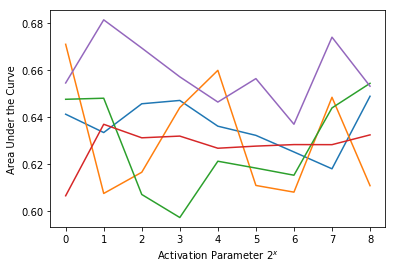

In [18]:
for series in auc:
    plt.plot(series)
plt.xlabel("Activation Parameter $2^x$")
plt.ylabel("Area Under the Curve")

Text(0,0.5,'Accuracy')

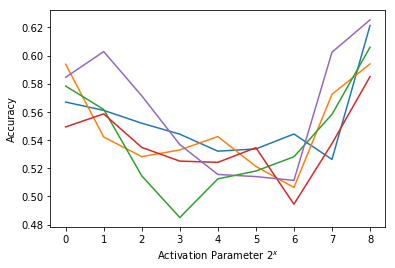

In [20]:
for series in acc:
    plt.plot(series)
plt.xlabel("Activation Parameter $2^x$")
plt.ylabel("Accuracy")

In [36]:
avg_weights = [[[np.mean(np.abs(np.sum(act[1][layer][0], axis=0))) for act in trial] for trial in output] for layer in range(3)]
avg_biases = [[[np.mean(np.abs(act[1][layer][1])) for act in trial] for trial in output] for layer in range(3)]

Text(0,0.5,'Average Absolute Weight')

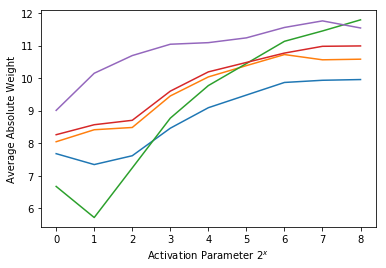

In [37]:
for series in avg_weights[0]:
    plt.plot(series)
plt.xlabel("Activation Parameter $2^x$")
plt.ylabel("Average Absolute Weight")

Text(0,0.5,'Average Absolute Bias')

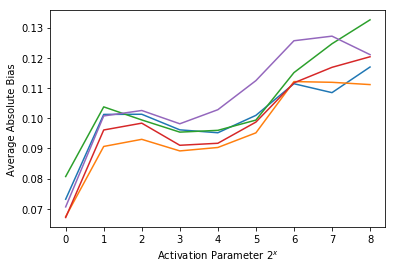

In [38]:
for series in avg_biases[0]:
    plt.plot(series)
plt.xlabel("Activation Parameter $2^x$")
plt.ylabel("Average Absolute Bias")

Text(0,0.5,'Average Absolute Weight')

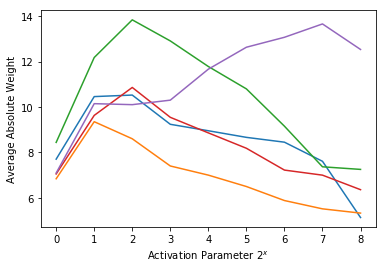

In [42]:
for series in avg_weights[1]:
    plt.plot(series)
plt.xlabel("Activation Parameter $2^x$")
plt.ylabel("Average Absolute Weight")

Text(0,0.5,'Average Absolute Bias')

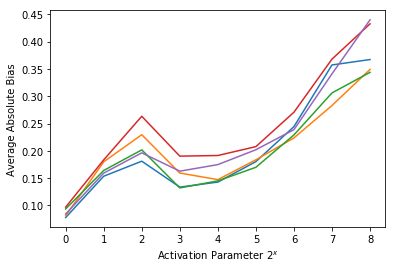

In [43]:
for series in avg_biases[1]:
    plt.plot(series)
plt.xlabel("Activation Parameter $2^x$")
plt.ylabel("Average Absolute Bias")

Text(0,0.5,'Average Absolute Weight')

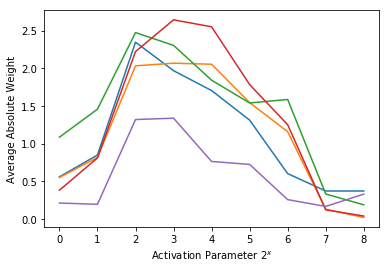

In [41]:
for series in avg_weights[2]:
    plt.plot(series)
plt.xlabel("Activation Parameter $2^x$")
plt.ylabel("Average Absolute Weight")

Text(0,0.5,'Average Absolute Bias')

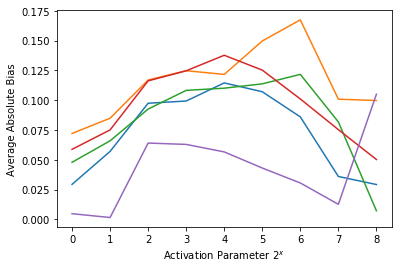

In [44]:
for series in avg_biases[2]:
    plt.plot(series)
plt.xlabel("Activation Parameter $2^x$")
plt.ylabel("Average Absolute Bias")